In [1]:
# 필요한 모듈 및 라이브러리 불러오기
import pandas as pd
import numpy as np
import random
import sys
import re
import datetime
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings(action='ignore')

# 한글 시각화 적용
import matplotlib.pyplot as plt
plt.rc('font', family='AppleGothic')
# 음수 표시를 위한 기호 설정
plt.rcParams['axes.unicode_minus'] = False

In [2]:
customer_db = pd.read_csv('/Users/JGH/Python/Section Project 4/customer_db.csv')
drink_db = pd.read_csv('/Users/JGH/Python/Section Project 4/drink_db.csv')
order_db = pd.read_csv('/Users/JGH/Python/Section Project 4/order_db.csv')
drink_allergy = pd.read_csv('/Users/JGH/Python/Section Project 4/drink_allergy.csv')

In [3]:
menu_count = order_db.groupby('drink_id')["id"].count().reset_index(drop=False)
menu_count.columns = ['id','sales']

In [4]:
drink = drink_db.merge(menu_count, on='id', how='inner')

In [5]:
# ice 제품을 만들기로 결정
drink = drink[drink.status=='Ice']
drink.reset_index(drop=True,inplace=True)
drink = drink.drop('status', axis=1)

In [6]:
# 카페인을 수치가 아닌 범주형 변수로 변경
drink['caffeine(mg)'] = drink['caffeine(mg)'].apply(lambda x: 'high' if x >= 53.25 else 'low')

In [7]:
drink['flavor'] = ['coffee','coffee','coffee','coffee','coffee',
                  'blend','coffee','coffee','coffee','coffee',
                  'coffee','coffee','blend','blend','blend',
                  'blend','blend','blend','blend','blend',
                  'blend','blend','blend', 'beverage','beverage',
                  'blend','beverage','beverage','beverage','beverage',
                  'beverage','beverage','beverage','beverage','beverage',
                  'beverage','beverage','beverage','beverage','beverage',
                  'beverage','beverage','beverage','beverage','beverage',
                  'beverage','blend','blend','blend','beverage',
                   'beverage','blend']

In [8]:
# 칼럼에서 단위 제거
drink.columns = ['id', 'name', 'category', 'price', 'calories', 'sugars',
                'protein', 'sodium', 'saturated_fat', 'caffeine',
                'sales', 'flavor']

In [9]:
# 알러지 유무 칼럼 추가
allergy_count = drink_allergy.groupby('name')['allergy'].count().reset_index()
drink = drink.merge(allergy_count, on='name', how='left')
drink['allergy'] = drink['allergy'].fillna(0)

In [10]:
# 아메리카노 인덱스 저장
ame_idx = drink[drink.name=='아이스 카페 아메리카노'].index.tolist()

In [11]:
# 예측에 필요하지 않은 칼럼 제거
drink = drink.drop(['id','name'], axis=1)

In [12]:
# 아메리카노 포함하지 않은 데이터 생성 (혼자 값이 너무 튀어서 예측 결과가 아메리카노를 설명하는 모델이 생성됨)
drink = drink.drop(ame_idx, axis=0)
drink.reset_index(drop=True,inplace=True)

In [13]:
drink

,category,price,calories,sugars,protein,sodium,saturated_fat,caffeine,sales,flavor,allergy
0,브루드 커피,4500,5,0,0.0,10.0,0.0,high,627,coffee,0.0
1,에스프레소,5900,190,22,6.0,110.0,4.6,high,980,coffee,2.0
2,에스프레소,5000,115,9,6.0,90.0,3.5,high,930,coffee,1.0
3,에스프레소,6300,270,14,3.0,45.0,18.0,high,901,coffee,1.0
4,에스프레소,6400,325,28,9.0,490.0,10.0,high,916,blend,2.0
5,에스프레소,6500,335,27,6.0,110.0,18.0,high,1019,coffee,1.0
6,에스프레소,6100,155,20,5.0,75.0,2.9,high,880,coffee,1.0
7,에스프레소,5900,230,35,10.0,145.0,2.5,high,928,coffee,1.0
8,에스프레소,5000,110,8,6.0,75.0,3.5,high,976,coffee,1.0
9,에스프레소,5500,250,21,7.0,70.0,8.0,high,944,coffee,1.0


In [13]:
# 변수 분리
target = 'sales'
X = drink.drop(columns=target) 
y = drink[target]

In [14]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [15]:
# 연속형 변수 스케일링
continuous_cols = ['price', 'calories', 'sugars', 'protein', 'sodium', 'saturated_fat','allergy']

scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [16]:
# 범주형 원핫인코딩
ohe = OneHotEncoder()
cat_cols = ['category', 'caffeine', 'flavor']

X_train_encoded = ohe.fit_transform(X_train[cat_cols])
X_train_encoded_dense = X_train_encoded.toarray()
X_train_encoded_df = pd.DataFrame(X_train_encoded_dense, columns=ohe.get_feature_names(cat_cols))
X_train_encoded_df.index = X_train.index

X_test_encoded = ohe.transform(X_test[cat_cols])
X_test_encoded_dense = X_test_encoded.toarray()
X_test_encoded_df = pd.DataFrame(X_test_encoded_dense, columns=ohe.get_feature_names(cat_cols))
X_test_encoded_df.index = X_test.index

In [17]:
X_train = pd.concat([X_train[continuous_cols], X_train_encoded_df], axis=1)
X_test = pd.concat([X_test[continuous_cols], X_test_encoded_df], axis=1)

In [18]:
# 모델 생성
model = LinearRegression()

In [19]:
from sklearn.metrics import r2_score

# 모델 피팅 및 K-Fold 교차 검증 수행
model = LinearRegression()
kf = KFold(n_splits=10)
cv_result_rmse = []
cv_result_r2 = []

for train_idx, val_idx in kf.split(X_train):
    X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    model.fit(X_train_cv, y_train_cv)
    y_pred_cv = model.predict(X_val_cv)
    
    mse_cv = mean_squared_error(y_val_cv, y_pred_cv).round(2)
    rmse_cv = np.sqrt(mse_cv).round(2)
    r2_score_cv = r2_score(y_val_cv, y_pred_cv).round(2)
    
    cv_result_rmse.append(rmse_cv)
    cv_result_r2.append(r2_score_cv)


filtered_r2 = np.array(cv_result_r2)[np.logical_and(np.array(cv_result_r2) >= 0, np.array(cv_result_r2) <= 1)]
mean_r2_score = np.mean(filtered_r2)


print('Average RMSE:', np.mean(cv_result_rmse).round(2))
print('Average R-squared score:', mean_r2_score.round(2))


Average RMSE: 162.91
Average R-squared score: 0.94


In [20]:
# 변수 해석
coef = model.coef_

# 변수 중요도 출력
for i, col in enumerate(X_train.columns):
    print(f'{col}: {coef[i]}')

price: -30.02716623924552
calories: -722.3193689622201
sugars: 351.91426555941274
protein: 120.05506626236179
sodium: 24.37545940788017
saturated_fat: 284.5918411828044
allergy: 43.19002005299228
category_기타 제조 음료: -797.6499705889473
category_브루드 커피: -550.8423034775285
category_블렌디드: 1275.8463711468503
category_에스프레소: -231.74749759322475
category_티: -1029.9506657690977
category_프라푸치노: 1334.3440662819453
caffeine_high: 17.41892117019991
caffeine_low: -17.418921170200363
flavor_beverage: 25.280004763436374
flavor_blend: 13.734139560207275
flavor_coffee: -39.01414432364368


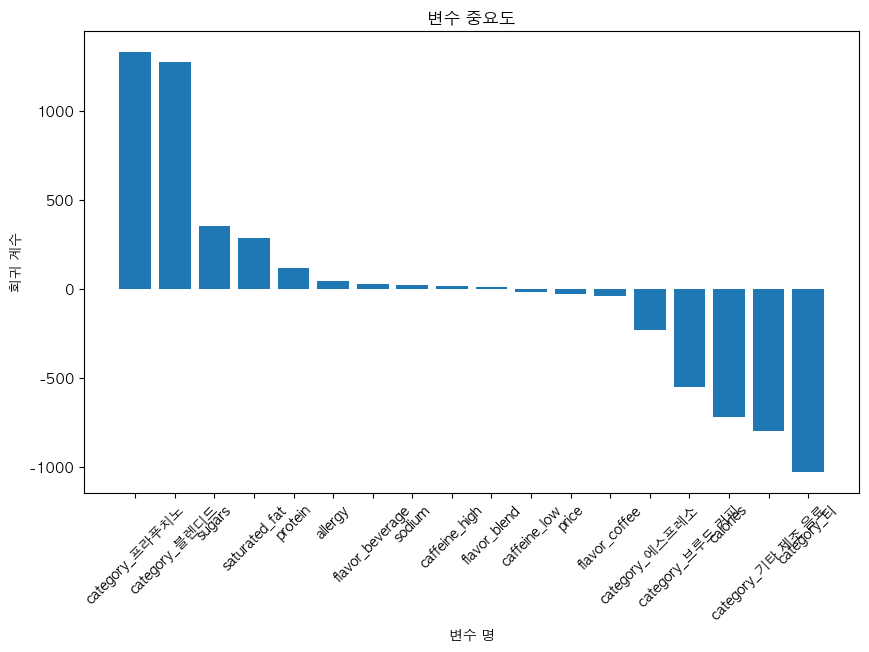

In [24]:
plt.figure(figsize=(10, 6))

sorted_indices = np.argsort(coef)[::-1]

sorted_coef = coef[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]
plt.bar(sorted_columns, sorted_coef)

plt.xlabel('변수 명')
plt.ylabel('회귀 계수')
plt.title('변수 중요도')
plt.xticks(rotation=45)
plt.show()

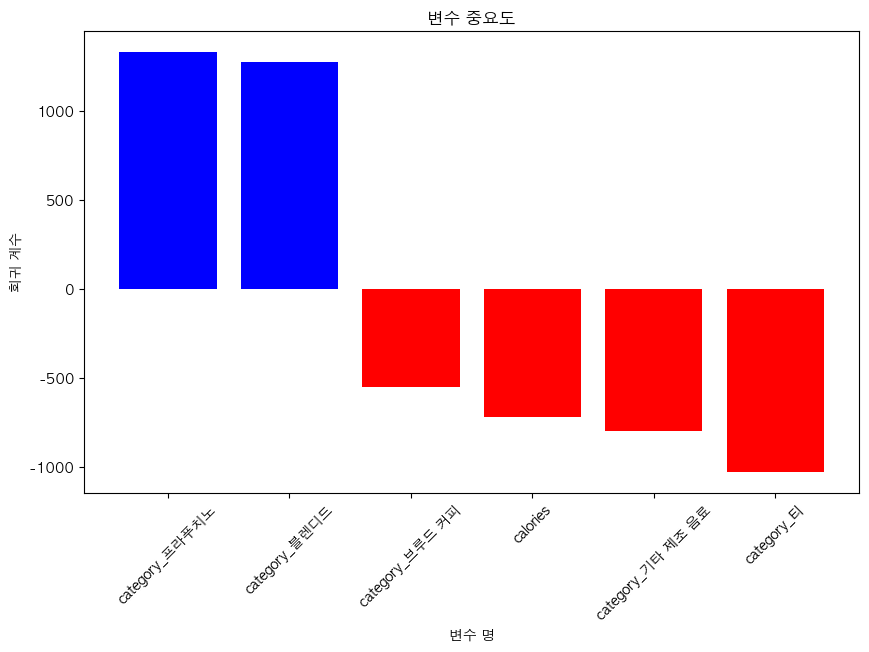

In [25]:
plt.figure(figsize=(10, 6))

coef = model.coef_
sorted_indices = np.argsort(coef)[::-1]


sorted_coef = coef[sorted_indices]
sorted_columns = X_train.columns[sorted_indices]

selected_indices = np.where(np.abs(sorted_coef) >= 500)[0]
selected_coef = sorted_coef[selected_indices]
selected_columns = sorted_columns[selected_indices]

colors = ['red' if c < 0 else 'blue' for c in selected_coef]

plt.bar(selected_columns, selected_coef, color=colors)

plt.xlabel('변수 명')
plt.ylabel('회귀 계수')
plt.title('변수 중요도')
plt.xticks(rotation=45)
plt.show()

In [23]:
# 테스트 데이터
y_pred_test = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test).round(2)
rmse_test = np.sqrt(mse_test).round(2)
r2_score_test = r2_score(y_test, y_pred_test)


print('RMSE for test data: ', rmse_test)
print('R-squared for test data: ', r2_score_test)

RMSE for test data:  149.94
R-squared for test data:  0.9773774473509763


In [26]:
X_test

,price,calories,sugars,protein,sodium,saturated_fat,allergy,category_기타 제조 음료,category_브루드 커피,category_블렌디드,category_에스프레소,category_티,category_프라푸치노,caffeine_high,caffeine_low,flavor_beverage,flavor_blend,flavor_coffee
43,-0.081699,-0.086836,0.139562,0.313535,-0.258576,-0.265614,-0.164344,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
40,-1.659326,-1.517073,-1.557070,-1.287497,-0.937464,-1.000396,-0.894763,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
46,0.143677,-0.461422,-0.681389,0.313535,-0.178707,-0.285473,-0.164344,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
12,0.030989,-0.529528,0.030102,-0.753819,-0.018969,-0.781947,-0.164344,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
24,1.270554,0.968816,0.851052,1.380890,0.979396,0.389732,-0.164344,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
31,0.932491,2.399053,2.930795,3.248761,0.979396,0.786912,-0.164344,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
17,1.608617,1.615828,1.562543,0.847213,1.059265,0.985501,1.296493,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
32,0.932491,0.117484,0.358482,-0.753819,-0.338446,-0.841524,0.566074,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,0.369052,0.321803,-0.790849,-0.486981,-0.578053,2.574219,-0.164344,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
30,0.932491,1.411508,3.587556,-0.753819,-0.777726,-1.000396,-0.894763,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [ ]:
# 신규 데이터 예측
# 주의사항 : category는 기존 category로 주어져야 한다
# 아마 페이지에서 입력하는 방식?

In [40]:
# 새로운 데이터로 판매량 예측 가능?
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

# 전처리된 데이터 프레임 생성
new_data = pd.DataFrame({'category': ['브루드 커피'], 'price': [5000], 'calories': [150], 'sugars': [39], 'protein': [0],
                         'sodium': [45], 'saturated_fat': [0], 'caffeine': ['high'], 'flavor': ['blend'], 'allergy': [0]})



In [43]:
# 전처리 과정 적용
continuous_cols = ['price', 'calories', 'sugars', 'protein', 'sodium', 'saturated_fat','allergy']
cat_cols = ['category', 'caffeine', 'flavor']

new_data[continuous_cols] = scaler.transform(new_data[continuous_cols])
new_data_encoded = ohe.transform(new_data[cat_cols])

In [45]:
new_data_encoded_dense = new_data_encoded.toarray()
new_data_encoded_df = pd.DataFrame(new_data_encoded_dense, columns=ohe.get_feature_names(cat_cols))
new_data_encoded_df.index = new_data.index

In [46]:
new_data = pd.concat([new_data[continuous_cols], new_data_encoded_df], axis=1)

In [48]:
new_data

,price,calories,sugars,protein,sodium,saturated_fat,allergy,category_기타 제조 음료,category_브루드 커피,category_블렌디드,category_에스프레소,category_티,category_프라푸치노,caffeine_high,caffeine_low,flavor_beverage,flavor_blend,flavor_coffee
0,-1.095888,-0.495475,0.577402,-1.287497,-0.578053,-1.000396,-0.894763,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [50]:
# 모델 예측
predicted_values = model.predict(new_data)
print("Predicted values:", predicted_values[0])

Predicted values: 707.4722797540002
